In [144]:
import numpy as np
import torch
import torch.nn as nn
import scipy
import scipy.io
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from scipy.stats import qmc

# Importing Data

In [145]:
mat = scipy.io.loadmat('/kaggle/input/nls-mat/NLS.mat')

In [146]:
x_phys = mat['x']
t_phys = mat['tt']
usol = mat['uu']
magnitudes = np.absolute(usol)
print(usol.shape)
print(x_phys.shape)
print(t_phys.shape)
print(mat.keys())

(256, 201)
(1, 256)
(1, 201)
dict_keys(['__header__', '__version__', '__globals__', 'tt', 'uu', 'x'])


<bound method Figure.show of <Figure size 1500x1000 with 2 Axes>>

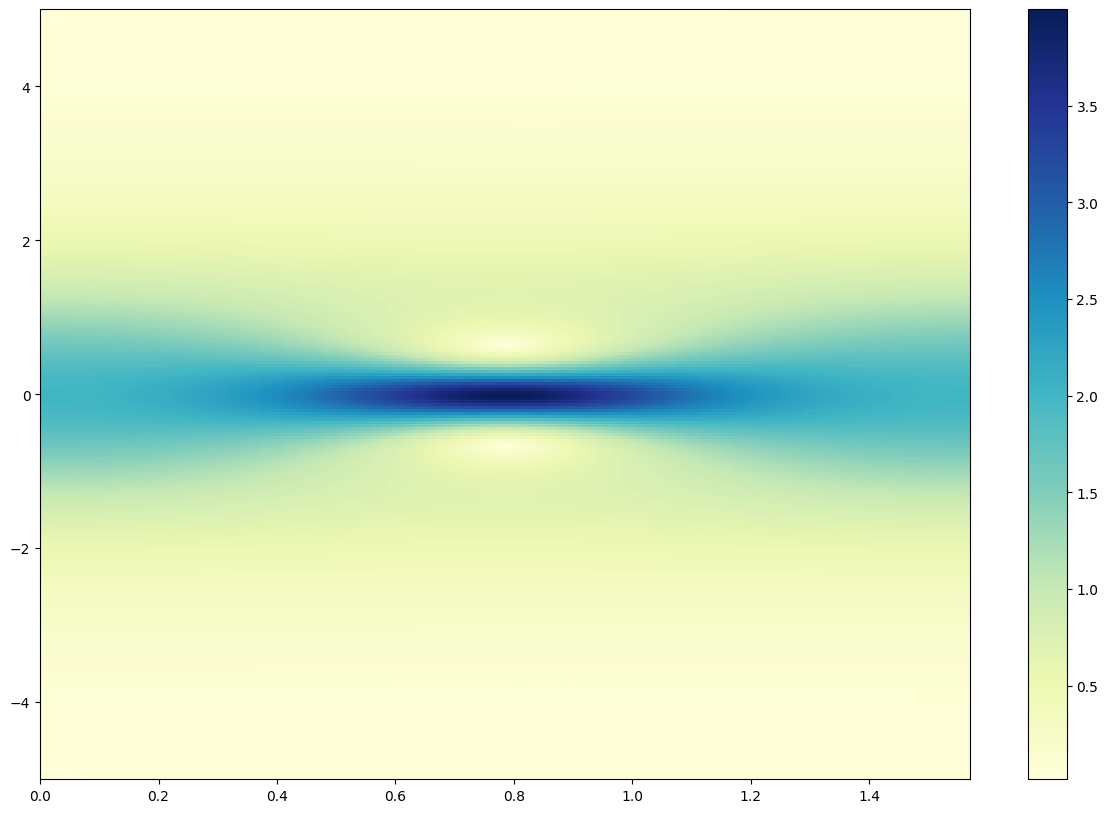

In [147]:
fig, ax = plt.subplots(1,figsize=(15,10))
img = ax.imshow(np.absolute(usol), cmap='YlGnBu', aspect='auto', extent=[0, np.pi / 2, -5, 5])
fig.colorbar(img)
fig.show

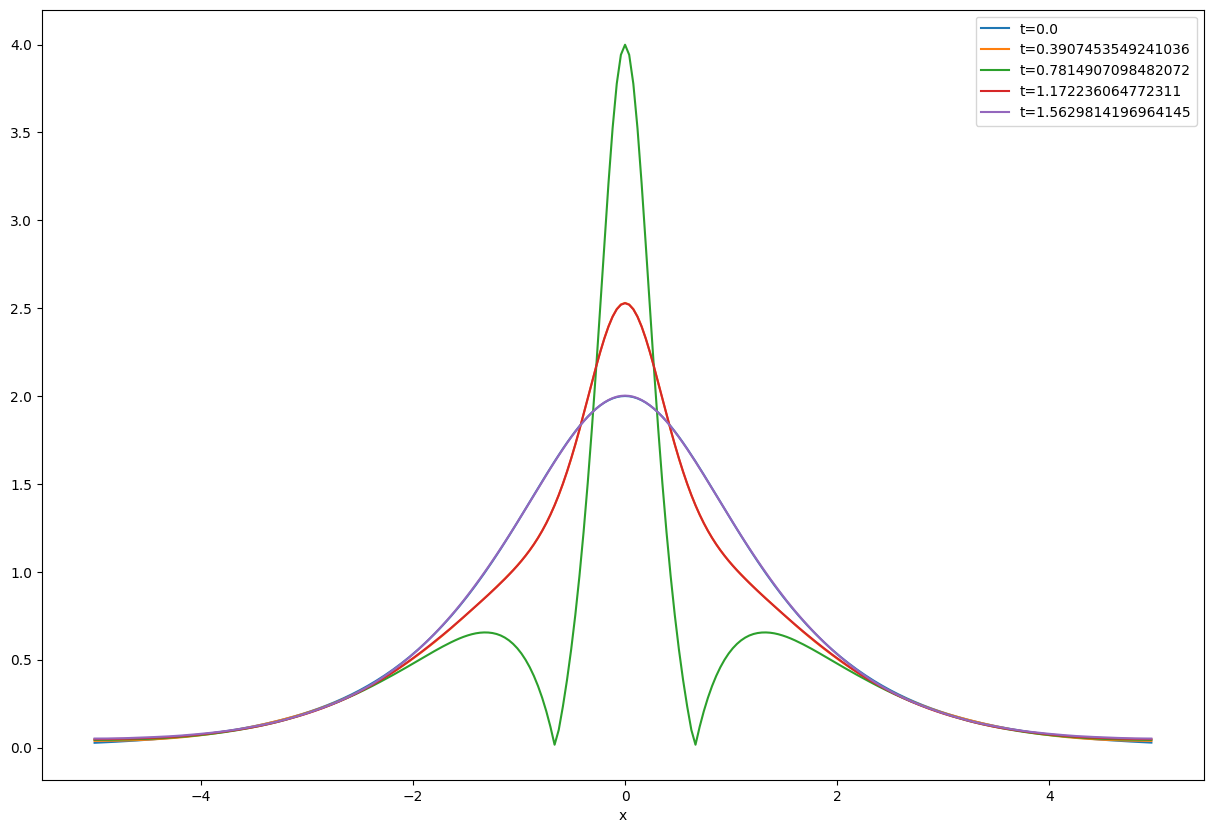

In [148]:
fig, ax = plt.subplots(1,figsize=(15,10))
for j in [0,50,100,150,200]:
    ax.plot(x_phys.reshape(-1), magnitudes[:,j].reshape(-1), label = f"t={(np.pi / 2) * j/t_phys.shape[1]}")
ax.set_xlabel('x')
ax.legend()
fig.show()

# Defining Model

In [149]:
class ScalingLayer(nn.Module):
    def __init__(self, scale_init_value=1, bias_init_value=0):
        super().__init__()
        self.scale = nn.Parameter(torch.FloatTensor([scale_init_value]))
        self.bias = nn.Parameter(torch.FloatTensor([bias_init_value]))

    def forward(self, input):
        return input * self.scale + self.bias


class U(nn.Module):
    def __init__(self, in_shape, out_shape, hidden_shapes):
        super().__init__()

        real_in_shape = in_shape
        imag_in_shape = in_shape
        
        self.real_layers = nn.ModuleList()
        # self.real_layers.append(ScalingLayer())
        for hidden in hidden_shapes:
            self.real_layers.append(nn.Linear(real_in_shape, hidden))
            self.real_layers.append(nn.Tanh())
            real_in_shape = hidden
        self.real_layers.append(nn.Linear(hidden_shapes[-1], out_shape))
        
        self.imag_layers = nn.ModuleList()
        # self.imag_layers.append(ScalingLayer())
        for hidden in hidden_shapes:
            self.imag_layers.append(nn.Linear(imag_in_shape, hidden))
            self.imag_layers.append(nn.Tanh())
            imag_in_shape = hidden
        self.imag_layers.append(nn.Linear(hidden_shapes[-1], out_shape))

    def forward(self, x):
        x_real = torch.real(x)
        x_imag = torch.imag(x)
        for layer in zip(self.real_layers, self.imag_layers):
            x_real = layer[0](x_real)
            x_imag = layer[1](x_imag)
        x = x_real.cfloat() + (x_imag.cfloat() * 1.j)
        return x

class F(nn.Module):
    def __init__(self, in_shape, out_shape, hidden_shapes):
        super().__init__()

        self.layers = nn.ModuleList()
        #self.layers.append(ScalingLayer())
        for hidden in hidden_shapes:
            self.layers.append(nn.Linear(in_shape, hidden, dtype=torch.cfloat))
            self.layers.append(nn.Sigmoid())
            in_shape = hidden
        self.layers.append(nn.Linear(hidden_shapes[-1], out_shape, dtype=torch.cfloat))

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

# Generating Collocation Points

In [150]:
def generate_latin_hyper_c_sampling(Nd=20000):
    sampler = qmc.LatinHypercube(d=2)
    sample = sampler.random(n=Nd//2)
    
    return qmc.scale(sample, l_bounds=[-5,0], u_bounds=[5,np.pi / 2])

In [151]:
collocation_p = generate_latin_hyper_c_sampling(10**4)

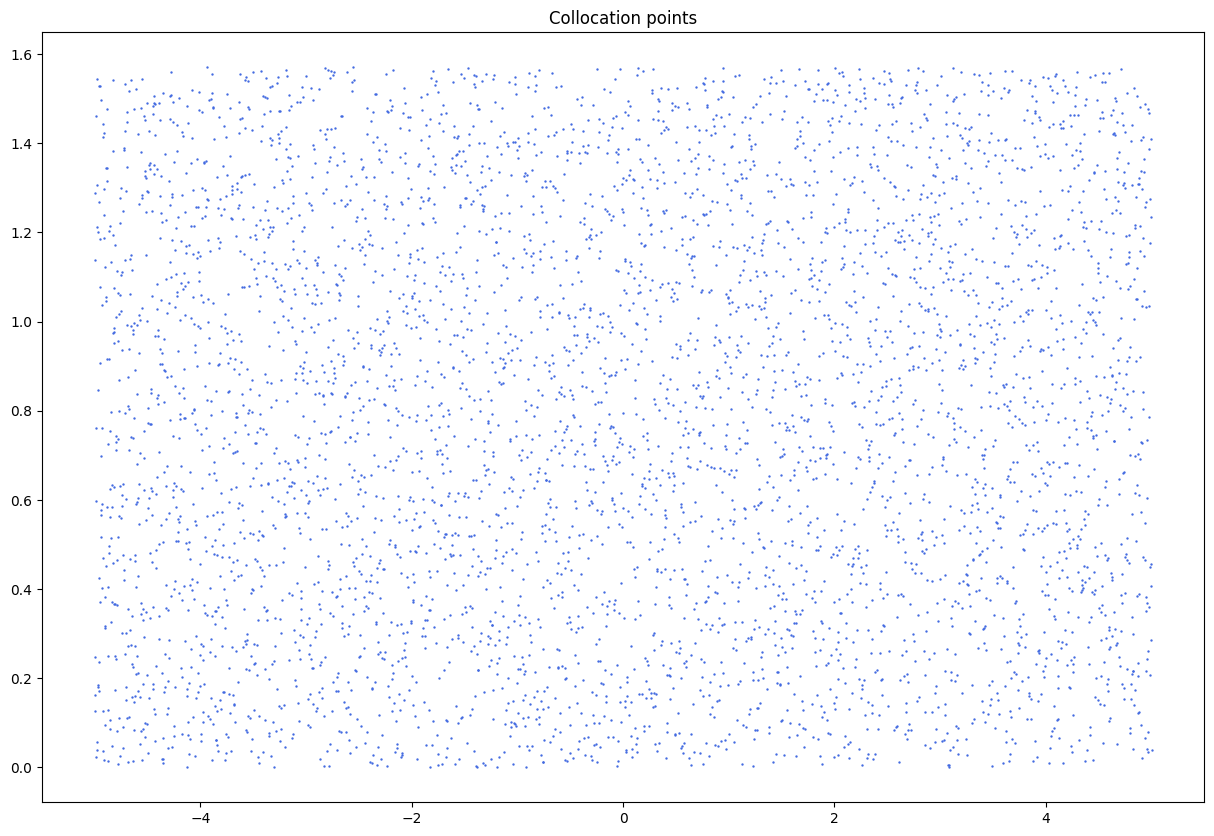

In [152]:
fig, ax = plt.subplots(1,figsize=(15,10))
ax.scatter(collocation_p[:,0], collocation_p[:,1], s=0.5, color='royalblue')
ax.set_title('Collocation points')
fig.show()

# Generating Training Data

In [153]:
def get_train_data(n, t, usol, noise=5e-3):
    t_index = int(2*t*usol.shape[1]/np.pi)
    
    print(t_index)

    x_indices = np.arange(0, usol.shape[0], usol.shape[0]//n)
    u_vals = usol[x_indices, t_index]
    u_vals = u_vals.reshape(-1,1)

    x_vals = ((x_indices * (10/256)) - 5)
    x_vals = x_vals.reshape(-1,1)
    t_vals = np.array([t]*x_vals.shape[0])
    t_vals = t_vals.reshape(-1,1)

    # INPUT: [[0,x1],[0,x2], [0,x3]...[0,x_n]], TARGET = u_vals

    noise = (np.random.normal(loc=0.0, scale=1.0, size=u_vals.shape[0]) * noise).reshape(-1,1)
    u_vals += noise + noise * 1.j

    return np.concatenate([x_vals, t_vals], axis=1), u_vals

In [154]:
train_data_t06, target_t06 = get_train_data(256, 0.6, usol, noise=0e-3)
train_data_t08, target_t08 = get_train_data(256, 0.8, usol, noise=0e-3)
train_data_t1, target_t1 = get_train_data(256, 1.0, usol, noise=0e-3)

train_data = np.concatenate([train_data_t06, train_data_t08, train_data_t1], axis=0)
train_targets = np.concatenate([target_t06, target_t08, target_t1], axis=0)

print(train_data.shape)
print(train_targets.shape)

76
102
127
(768, 2)
(768, 1)


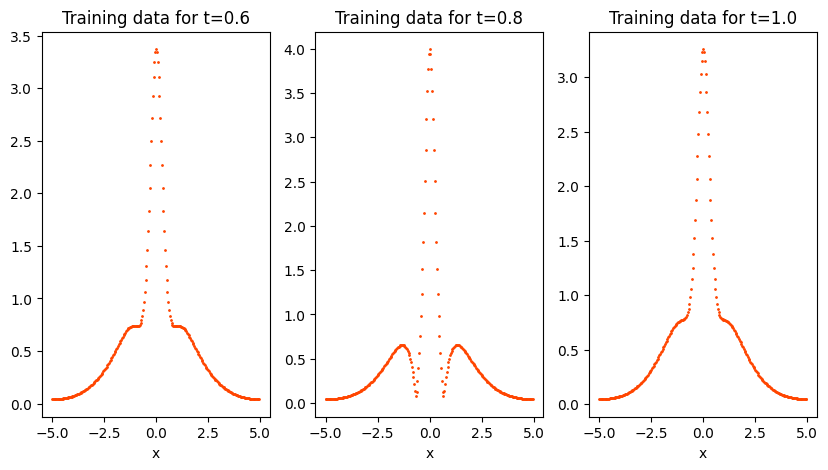

In [155]:
fig, ax = plt.subplots(1,3, figsize=(10,5))
ax[0].scatter(train_data_t06[:,0], np.absolute(target_t06[:,0]), s=1, color='orangered')
ax[0].set_title('Training data for t=0.6')
ax[0].set_xlabel('x')
ax[1].scatter(train_data_t08[:,0], np.absolute(target_t08[:,0]), s=1, color='orangered')
ax[1].set_title('Training data for t=0.8')
ax[1].set_xlabel('x')
ax[2].scatter(train_data_t1[:,0], np.absolute(target_t1[:,0]), s=1, color='orangered')
ax[2].set_title('Training data for t=1.0')
ax[2].set_xlabel('x')
fig.show()

# Generating Boundary Points

In [156]:
def get_boundary_points(n=100):
    sampler = qmc.LatinHypercube(d=1)
    sample = sampler.random(3*n)

    u_initial = lambda x: 2 / np.cosh(x)

    top_b = qmc.scale(sampler.random(n), l_bounds=0, u_bounds=np.pi/2)
    top_b = np.concatenate([np.ones_like(top_b)*5, top_b],axis=1)
    
    bot_b = top_b.copy()
    bot_b[:,0] = bot_b[:,0] * -1
    
    x_b = qmc.scale(sampler.random(n), l_bounds=-5, u_bounds=5)
    x_b = np.concatenate([x_b, np.zeros_like(x_b)],axis=1)
    x_b_target = u_initial(x_b[:,0]).reshape(-1,1)

    return top_b, bot_b, x_b, x_b_target

top_boundary_points, bottom_boundary_points, initial_boundary_points, initial_boundary_targets = get_boundary_points(100)

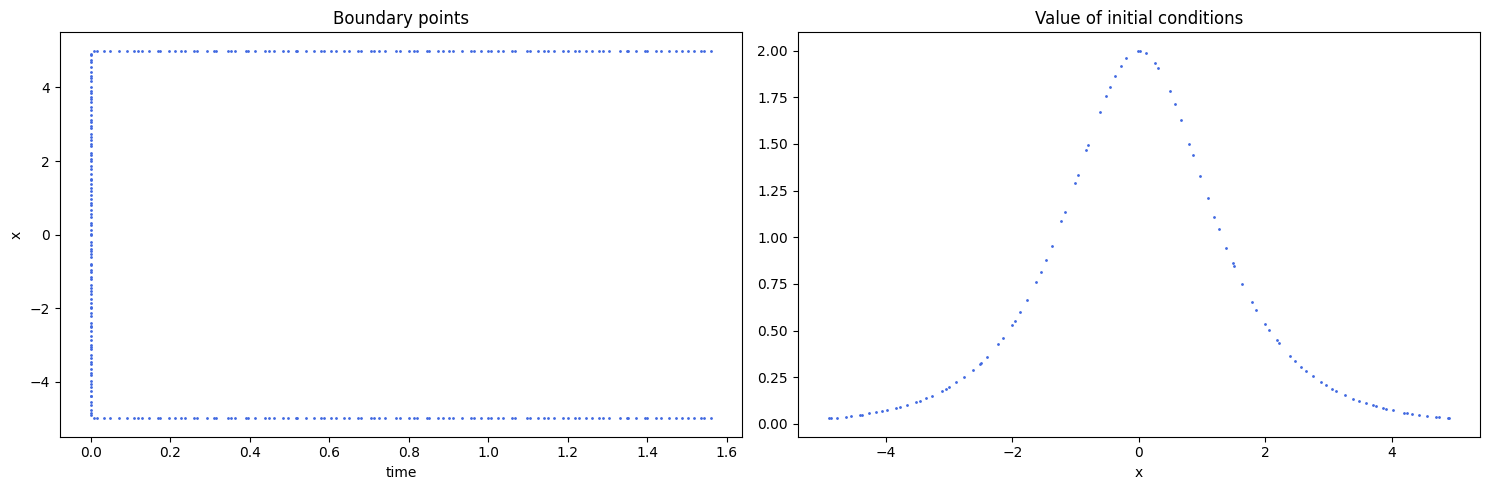

In [157]:
fig, ax = plt.subplots(1,2, figsize=(15,5))

ax[0].scatter(np.concatenate([top_boundary_points, bottom_boundary_points, initial_boundary_points], axis=0)[:,1], 
              np.concatenate([top_boundary_points, bottom_boundary_points, initial_boundary_points], axis=0)[:,0], s=1.0, color='royalblue')
ax[0].set_title('Boundary points')
ax[0].set_xlabel('time')
ax[0].set_ylabel('x')

ax[1].scatter(initial_boundary_points[:,0], initial_boundary_targets, s=1.0, color='royalblue')
ax[1].set_title('Value of initial conditions')
ax[1].set_xlabel('x')

fig.tight_layout()

# Moving Data to Device

In [158]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

# put data on device
collocation_p = torch.from_numpy(collocation_p).cfloat().to(device).requires_grad_(True)
top_boundary_points = torch.from_numpy(top_boundary_points).cfloat().to(device)
bottom_boundary_points = torch.from_numpy(bottom_boundary_points).cfloat().to(device)
initial_boundary_points = torch.from_numpy(initial_boundary_points).cfloat().to(device)
initial_boundary_targets = torch.from_numpy(initial_boundary_targets).cfloat().to(device)
train_data = torch.from_numpy(train_data).cfloat().to(device)
train_targets = torch.from_numpy(train_targets).cfloat().to(device)

# Initializing Models

In [159]:
u = U(2,1, [100]*5)
u = u.to(device)

f = F(3,1, [20]*8)
f = f.to(device)

In [160]:
def complex_mse_loss(output, target):
    real_output = torch.real(output)
    imag_output = torch.imag(output)
    real_target = torch.real(target)
    imag_target = torch.imag(target)
    return torch.nn.MSELoss()(real_output, real_target) + torch.nn.MSELoss()(imag_output, imag_target)

In [161]:
collocation_loss = torch.zeros((collocation_p.shape[0],1))
data_point_loss = torch.zeros_like(train_targets)

In [162]:
print(data_point_loss.shape)

torch.Size([768, 1])


# Loss Function

In [163]:
def get_loss(top_boundary_points, bottom_boundary_points, initial_boundary_points, initial_boundary_targets, collocation_p, train_data, train_targets, lambdas):
    lambda1, lambda2, lambda3 = lambdas[0], lambdas[1], lambdas[2]
    collocation_quota = 1.0
    global collocation_loss
    global data_point_loss
    
    # boundary loss -------
    # h(0,x) = 2 * sech(x)
    u_b = u(initial_boundary_points)
    # h(t,5) = h(t,-5)
    top_boundary_points = top_boundary_points.requires_grad_(True)
    u_b_t = u(top_boundary_points)
    bottom_boundary_points = bottom_boundary_points.requires_grad_(True)
    u_b_b = u(bottom_boundary_points)
    # h_x(t,5) = h_x(t,-5)
    du_b_tdxt = torch.autograd.grad(u_b_t, top_boundary_points, torch.ones_like(u_b_t), create_graph=True)[0]
    du_b_bdxt = torch.autograd.grad(u_b_b, bottom_boundary_points, torch.ones_like(u_b_b), create_graph=True)[0]
    # Adding boundry losses together
    loss1 = complex_mse_loss(u_b, initial_boundary_targets) + complex_mse_loss(u_b_t, u_b_b) + complex_mse_loss(du_b_tdxt[:,0], du_b_bdxt[:,0])


    # Physics loss -------
    u_p = u(collocation_p)
    # retain graph?
    dudxt = torch.autograd.grad(u_p, collocation_p, torch.ones_like(u_p), create_graph=True)[0]
    dudt = dudxt[:,1].reshape(-1,1)
    dudx = dudxt[:,0].reshape(-1,1)

    du2dx2 = torch.autograd.grad(dudxt, collocation_p,
                                 torch.ones_like(dudxt), create_graph=True)[0][:,0].reshape(-1,1)

#     f_input = torch.cat([u_p,dudt.reshape(-1,1),dudx.reshape(-1,1)], axis=1)
#     f_p = f(f_input)

#     h_real = torch.real(dudt) + 0.5*torch.imag(du2dx2) + (torch.real(u_p)**2 + torch.imag(u_p)**2)*torch.imag(u_p)
#     h_imag = torch.imag(dudt) - 0.5*torch.real(du2dx2) - (torch.real(u_p)**2 + torch.imag(u_p)**2)*torch.real(u_p)
    
#     collocation_loss = h_real + h_imag
    
    collocation_loss = dudt * 1.j + 0.5 * du2dx2.reshape(-1,1) + torch.absolute(u_p)**2 * u_p

#     flat_collocation_loss = collocation_loss.reshape(-1)
#     top_indices = torch.topk(torch.abs(flat_collocation_loss), int(1000 * collocation_quota), largest=True)[1]
#     mask = torch.zeros_like(flat_collocation_loss, dtype=torch.bool)
#     mask[top_indices] = True
#     masked_collocation_loss = flat_collocation_loss* mask * (1/collocation_quota)

    loss2 = complex_mse_loss(collocation_loss, torch.zeros_like(collocation_loss))

#     loss2 = torch.nn.MSELoss()(collocation_loss, torch.zeros_like(collocation_loss))

    # Datapoint loss -------
    u_n = u(train_data)
    loss3 = complex_mse_loss(u_n, train_targets)
    
    with torch.no_grad():
        data_point_loss = torch.absolute(u_n - train_targets)

    loss = lambda1*loss1 + lambda2*loss2  + lambda3*loss3
    return loss, loss1, loss2, loss3

# Plotting Function

In [164]:
def plot_solution(usol, u, f):
    unk_point = 0.9

    # Compute u, dudx and F(u, dudx, dudt) to plot the true, estimated and learned unknown component N_k
    # The unknown component should be: -u * dudx
#     x_points = (torch.linspace(-5,5,1000)).reshape(-1,1).cfloat()
#     t_points = (torch.ones_like(x_points)*unk_point).reshape(-1,1).cfloat()
#     xt_points = torch.cat([x_points, t_points], axis=1).to(device).requires_grad_(True)

#     u_plot = u(xt_points)

#     dudxt_plot = torch.autograd.grad(u_plot, xt_points, torch.ones_like(u_plot), create_graph=True)[0]
#     dudt_plot = dudxt_plot[:,0].reshape(-1,1)
#     dudx_plot = dudxt_plot[:,1].reshape(-1,1)
#     f_input_plot = torch.cat([u_plot, dudt_plot,dudx_plot], axis=1)
#     f_plot = f(f_input_plot)

    # Compute dudx from the true solution u using finite difference
    # We consider the timestep t=0.75 so that the result is interpretable
    # and it is a timestep without any training data
#     true_u = usol[:,int(unk_point*200)]
#     dudx_upwind = np.zeros((1000,1))

#     dx = 2 / 1000
#     for i in range(1, true_u.shape[0]-1):
#             if true_u[i] >= 0:
#                     dudx_upwind[i] = (true_u[i] - true_u[i-1]) / dx
#             else:
#                     dudx_upwind[i] = (true_u[i+1] - true_u[i]) / dx

    with torch.no_grad():
            # Get a meshgrid of points to display an image of the solution u in the
            # domain x=[-1,1] and t=[0,1]
            t_phys = np.linspace(0, np.pi / 2, 201)
            x_phys = np.linspace(-5, 5, 256)
            t_mesh, x_mesh = np.meshgrid(t_phys, x_phys)

            coordinates = np.vstack((x_mesh.flatten(), t_mesh.flatten())).T
            coordinates = torch.Tensor(coordinates).to(device).cfloat()

            u_p = np.absolute(u(coordinates).detach().cpu().numpy())
            u_mesh = u_p.reshape(x_mesh.shape)

            data_min = np.min(u_p)
            data_max = np.max(u_p)

            # Contour plot
            fig, ax = plt.subplots(2,2,figsize=(30,10))
            norm = Normalize(vmin=data_min, vmax=data_max)
            img = ax[0,0].imshow(u_mesh, cmap='viridis',
                                 aspect='auto',
                                 extent=[0, np.pi / 2, 5, -5])
            fig.colorbar(img, ax=ax[0,0])

            ax[0,0].set_xlabel('t')
            ax[0,0].set_ylabel('x')
            ax[0,0].set_title('Contour plot of the Nonlinear Schrödinger Approximation')

            # Slices -----------------------------------------------------------
            # Visualize some of u predictions, for some values of t
#             for j in [0,50,100,150,200]:
#                 ax.plot(x.reshape(-1), magnitudes[:,j].reshape(-1), label = f"t={j/t.shape[1]}")
            colors = ['royalblue', 'forestgreen', 'darkorange', 'firebrick', 'pink']
            for i,(j,k) in enumerate(zip([0,76,102,127,200], [0,76,102,127,200])):
                ax[0,1].plot(np.linspace(-5, 5, 256), magnitudes[:,j],
                             label=f't={(np.pi/2)*j/magnitudes.shape[1]}', color=colors[i])
                ax[0,1].plot(np.linspace(-5, 5, u_mesh.shape[0]),
                             u_mesh[:,k], linestyle='--', color=colors[i])
            ax[0,1].set_xlabel('x')
            ax[0,1].legend()

#             # Unknown term -----------------------------------------------------
#             # plot the unknown term learned by F vs the true interaction
#             expected = -(u_plot * dudx_plot).detach().cpu().numpy()
#             ax[0,2].plot(np.linspace(-0.25, 0.25, 250), expected[375:625], label='Expected unknown')
#             ax[0,2].plot(np.linspace(-0.25, 0.25, 250), f_plot.detach().cpu().numpy()[375:625], label='F', linestyle='--')
#             ax[0,2].plot(np.linspace(-0.25, 0.25, 250), (-true_u.reshape(-1,1)*dudx_upwind)[375:625], label='True unknown')
#             ax[0,2].legend()
#             ax[0,2].set_title(f'Unknown term at time t={unk_point}')

#             # Locational physics loss ------------------------------------------
#             # Create a scatter plot with a colormap
#             img2 = ax[1,0].scatter(collocation_p[:,0].detach().cpu().numpy(),
#                                    collocation_p[:,1].detach().cpu().numpy(),
#                                    c=np.abs(collocation_loss.detach().cpu().numpy()),
#                                    cmap='YlOrRd', marker='.', edgecolors='none')
#             fig.colorbar(img2, ax=ax[1,0])

#             ax[1,0].set_xlabel('t')
#             ax[1,0].set_ylabel('x')
#             ax[1,0].set_title('Physics loss contribution')

            # Locational data point loss ---------------------------------------
            ax[1,1].plot(np.linspace(-5, 5, 256), data_point_loss[:256,0].detach().cpu().numpy(), label='t=0.6')
            ax[1,1].plot(np.linspace(-5, 5, 256), data_point_loss[256:512,0].detach().cpu().numpy(), label='t=0.8')
            ax[1,1].plot(np.linspace(-5, 5, 256), data_point_loss[512:,0].detach().cpu().numpy(), label='t=1.0')

            ax[1,1].set_xlabel('x')
            ax[1,1].legend()
            ax[1,1].set_title('Data point loss contribution')


            plt.show()
            return fig

# Training Model

In [165]:
# lr = 2e-2
# optimizer = torch.optim.Adam([*u.parameters(), *f.parameters()], lr=lr)
lr_u = 1e-4
lr_f = 1e-3
optimizer_u = torch.optim.Adam(u.parameters(), lr=lr_u)
optimizer_f = torch.optim.Adam(f.parameters(), lr=lr_f)

[0/50001] Boundary L: 0.7238879203796387, Phys L: 0.00033598157460801303, Data L: 0.7929303646087646


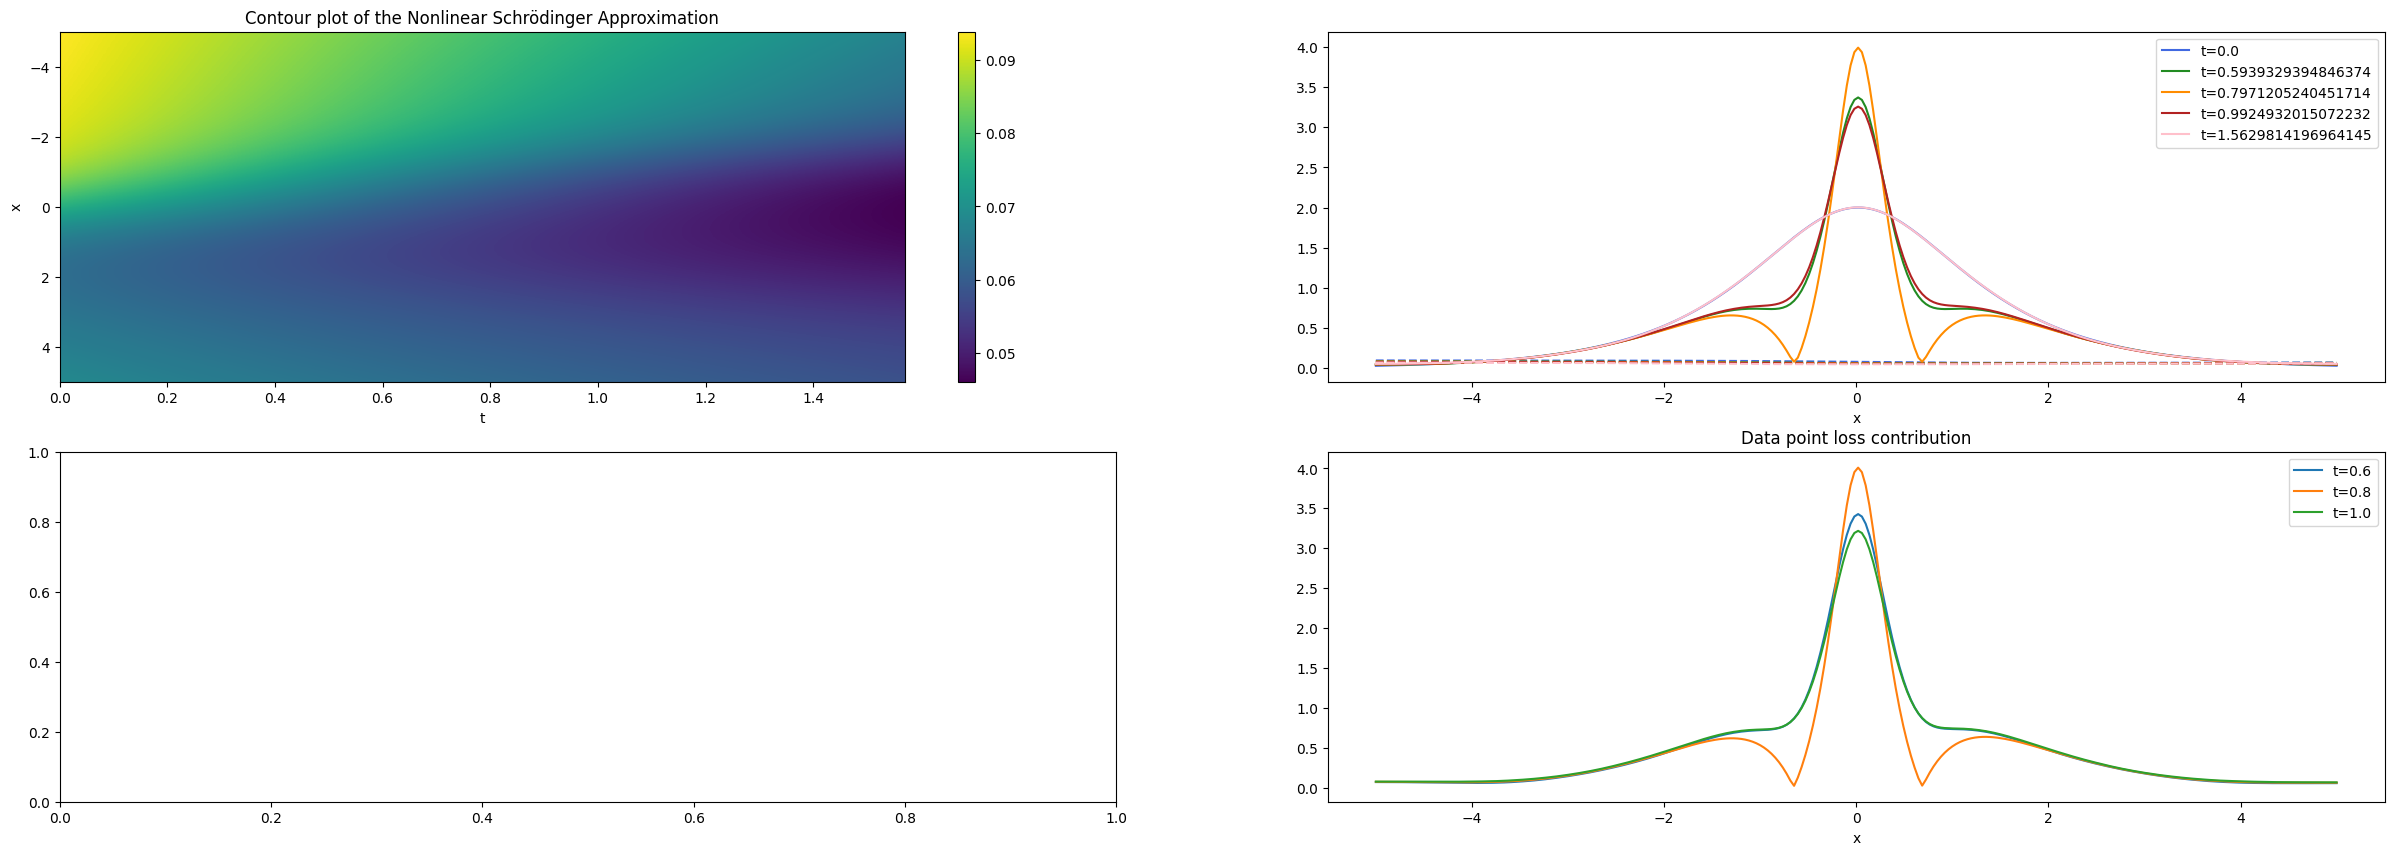

[5000/50001] Boundary L: 0.14299845695495605, Phys L: 0.11665119230747223, Data L: 0.7376018166542053


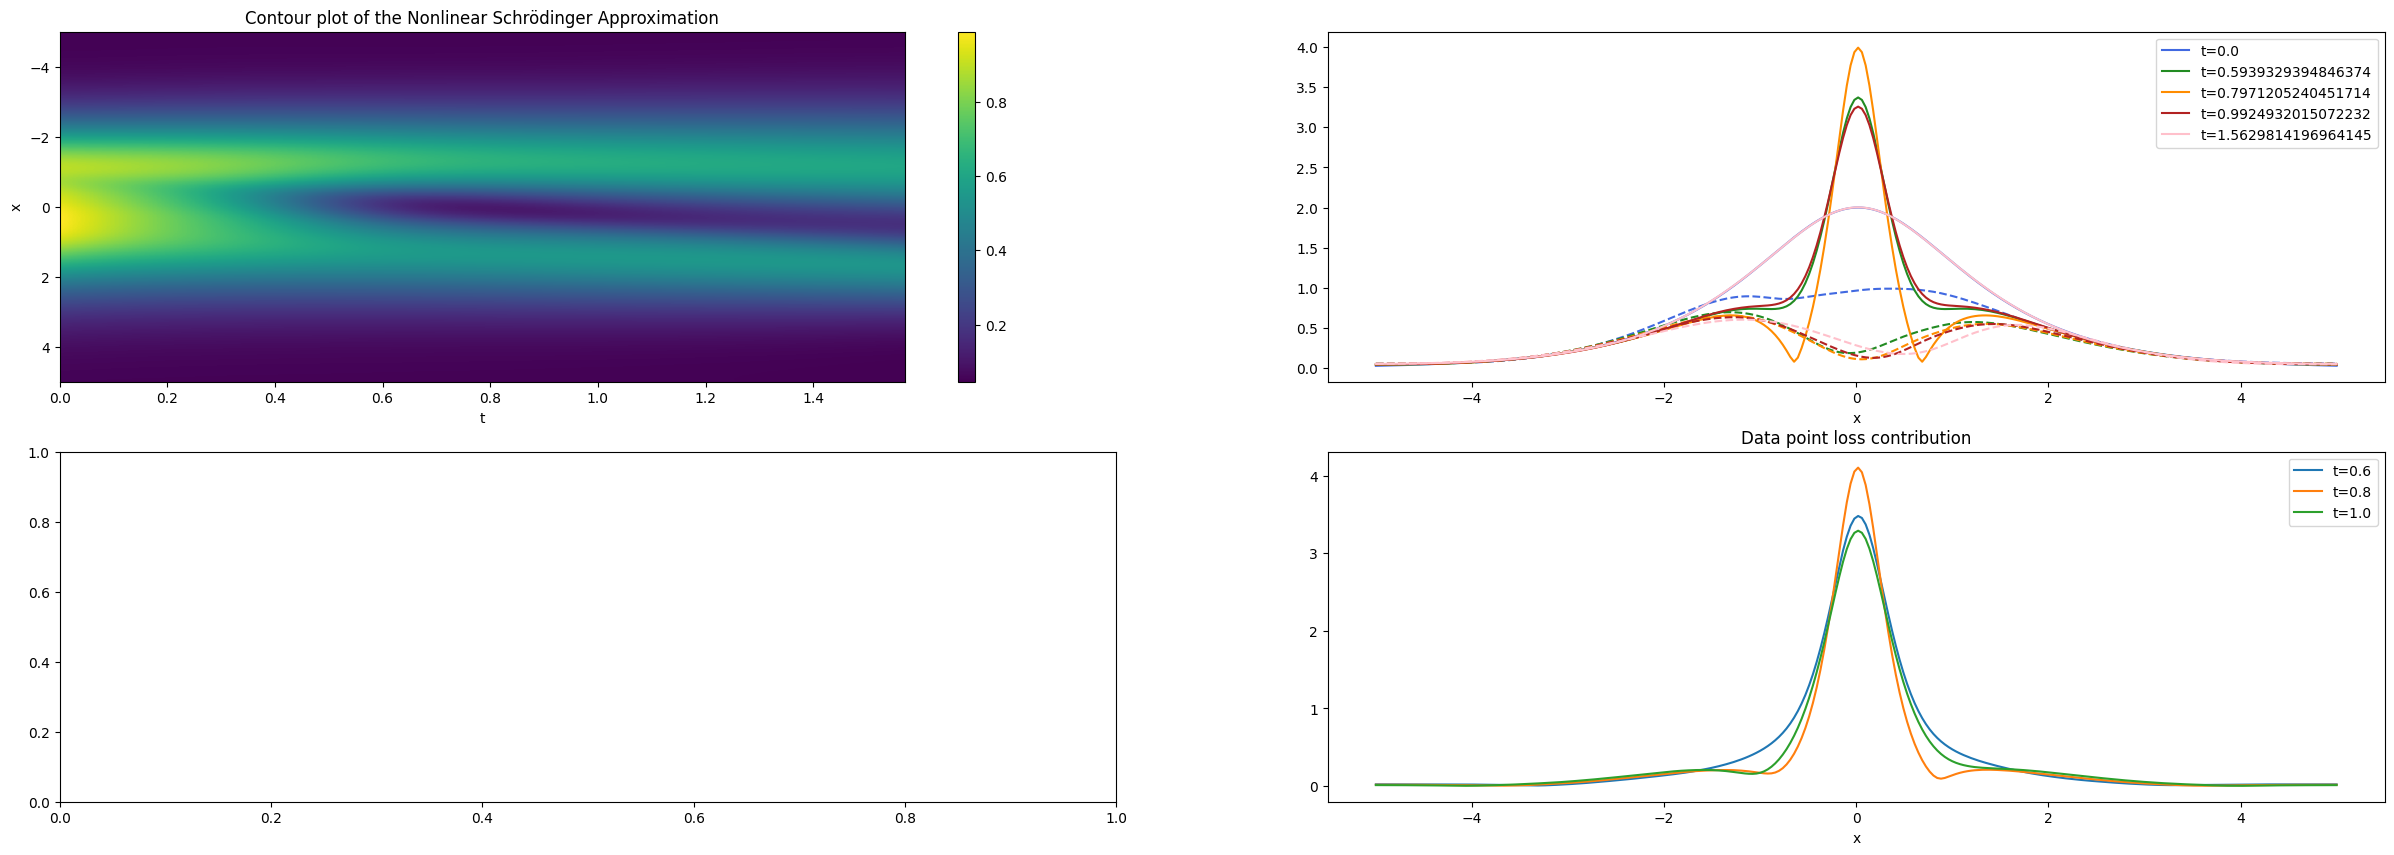

[10000/50001] Boundary L: 0.14170892536640167, Phys L: 0.11721795797348022, Data L: 0.7367334961891174


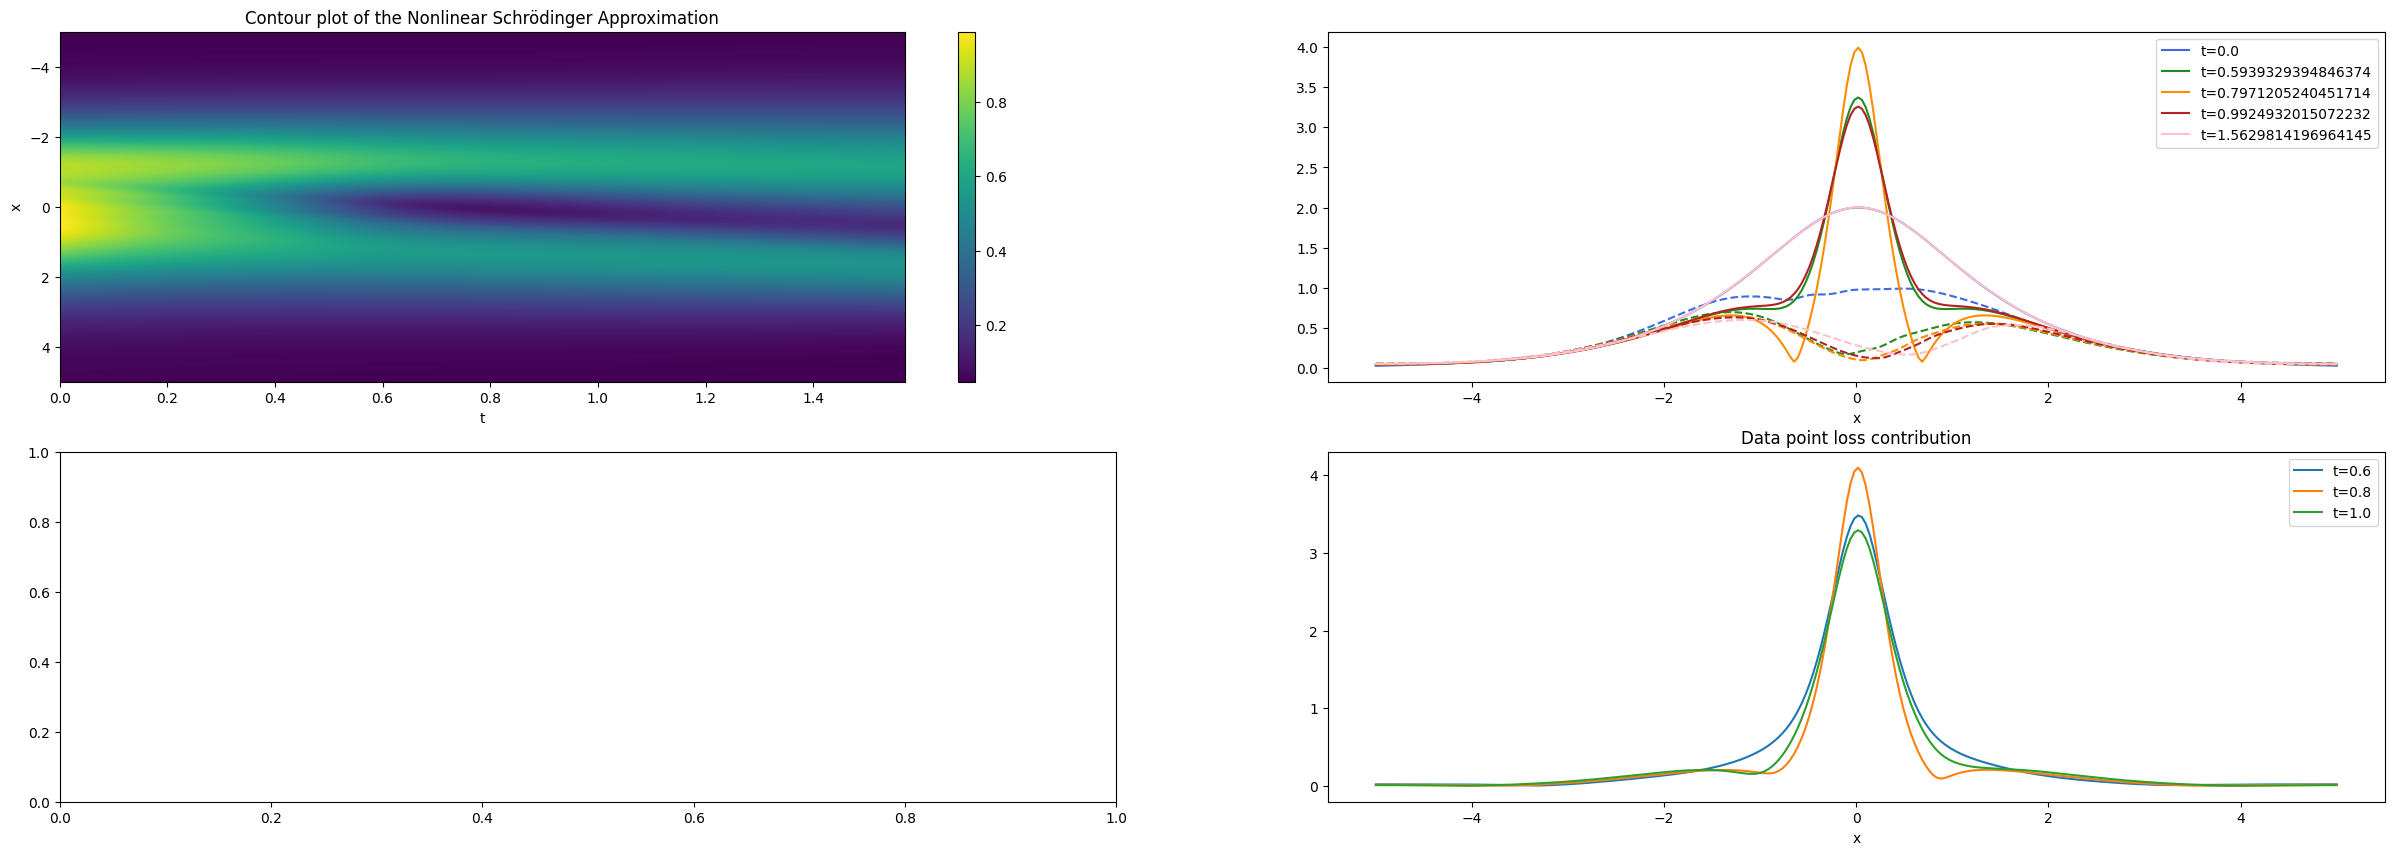

[15000/50001] Boundary L: 0.14054444432258606, Phys L: 0.11785018444061279, Data L: 0.7346813678741455


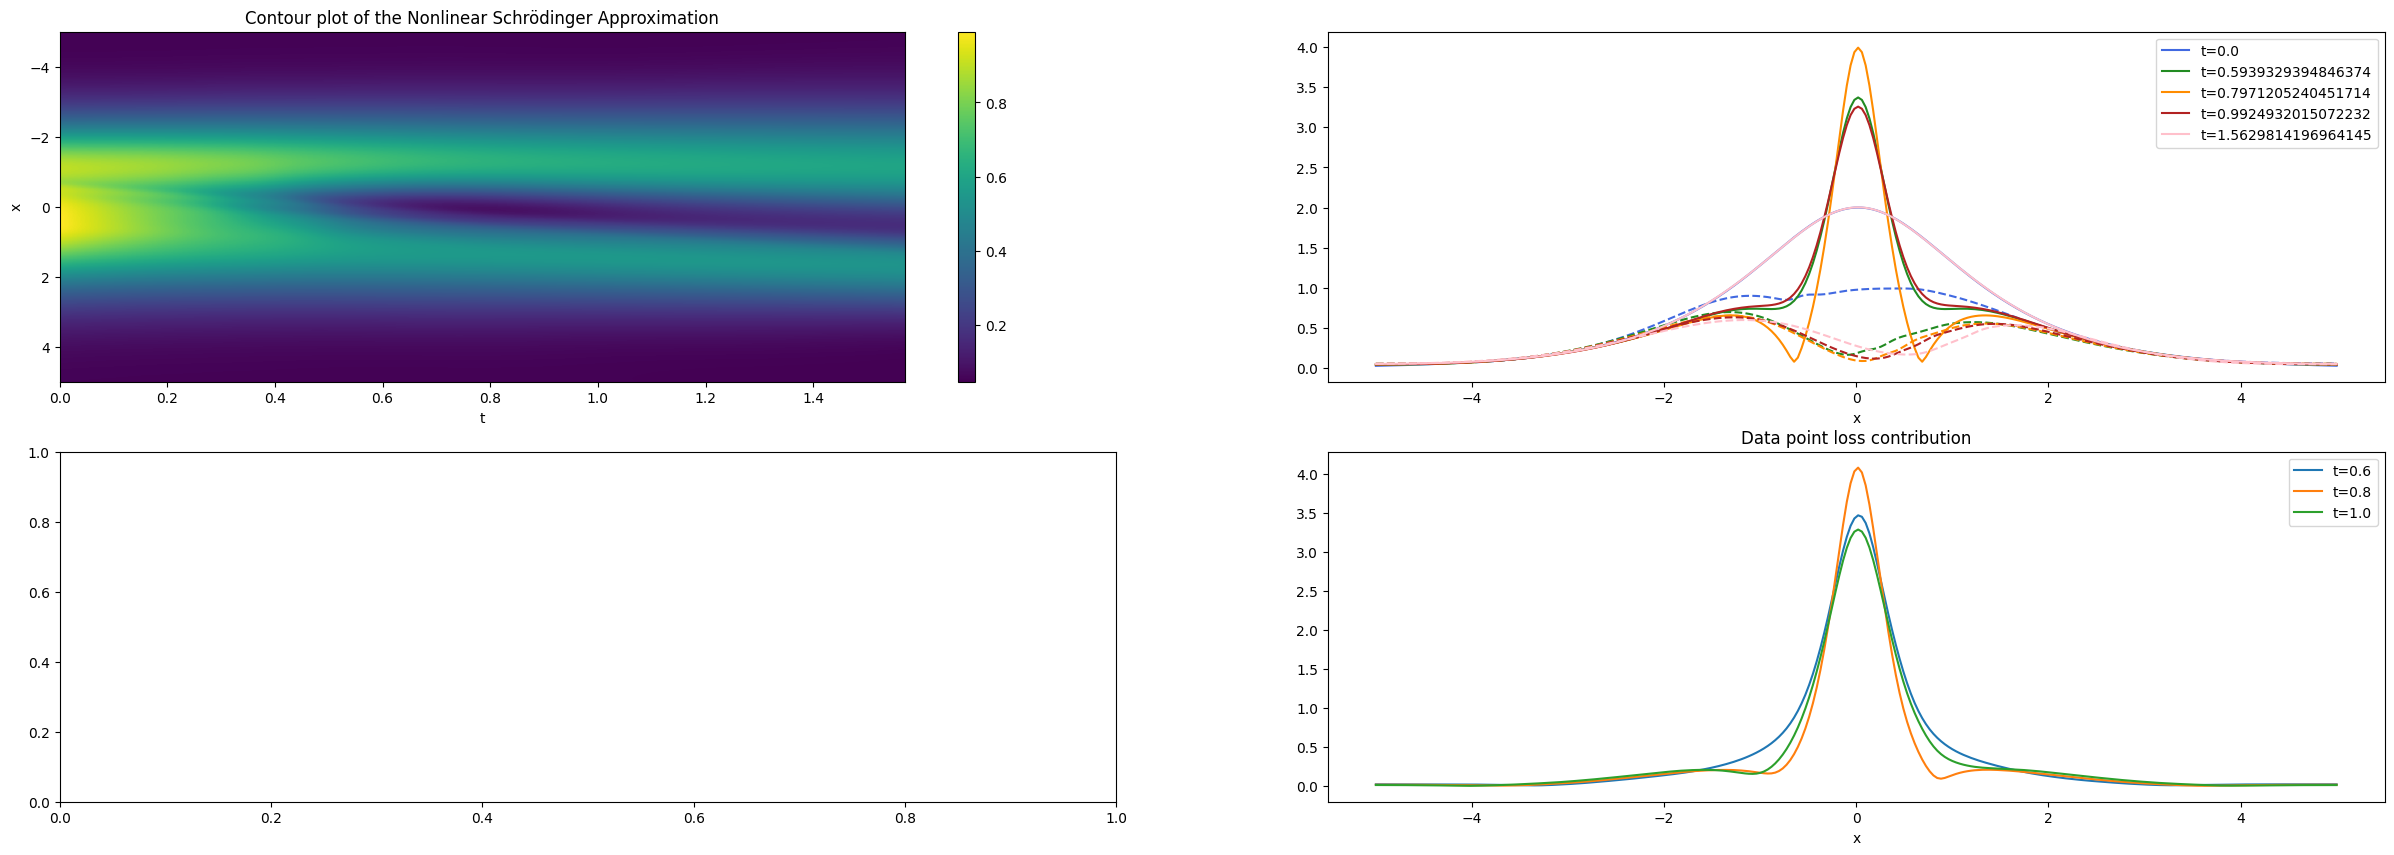

[20000/50001] Boundary L: 0.11071912944316864, Phys L: 0.12439458072185516, Data L: 0.6837674379348755


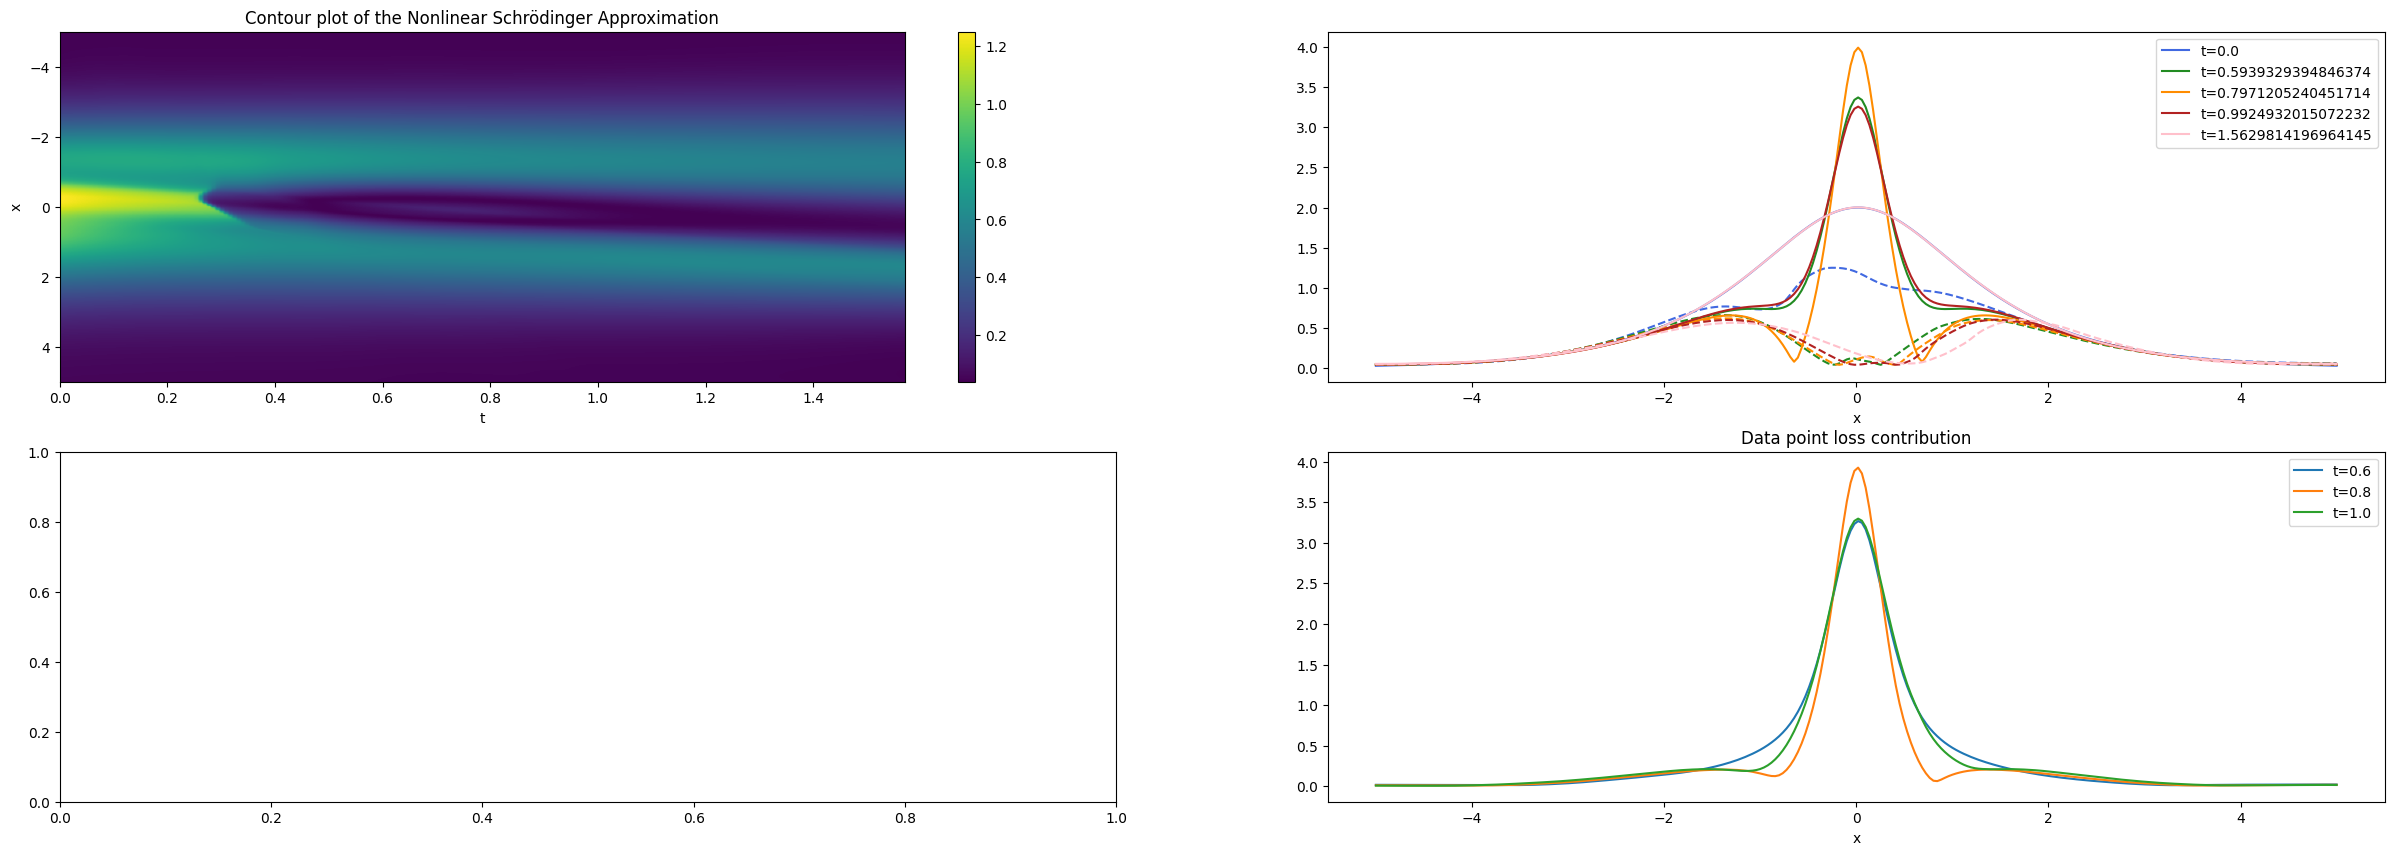

[25000/50001] Boundary L: 0.07658577710390091, Phys L: 0.12506720423698425, Data L: 0.6150112152099609


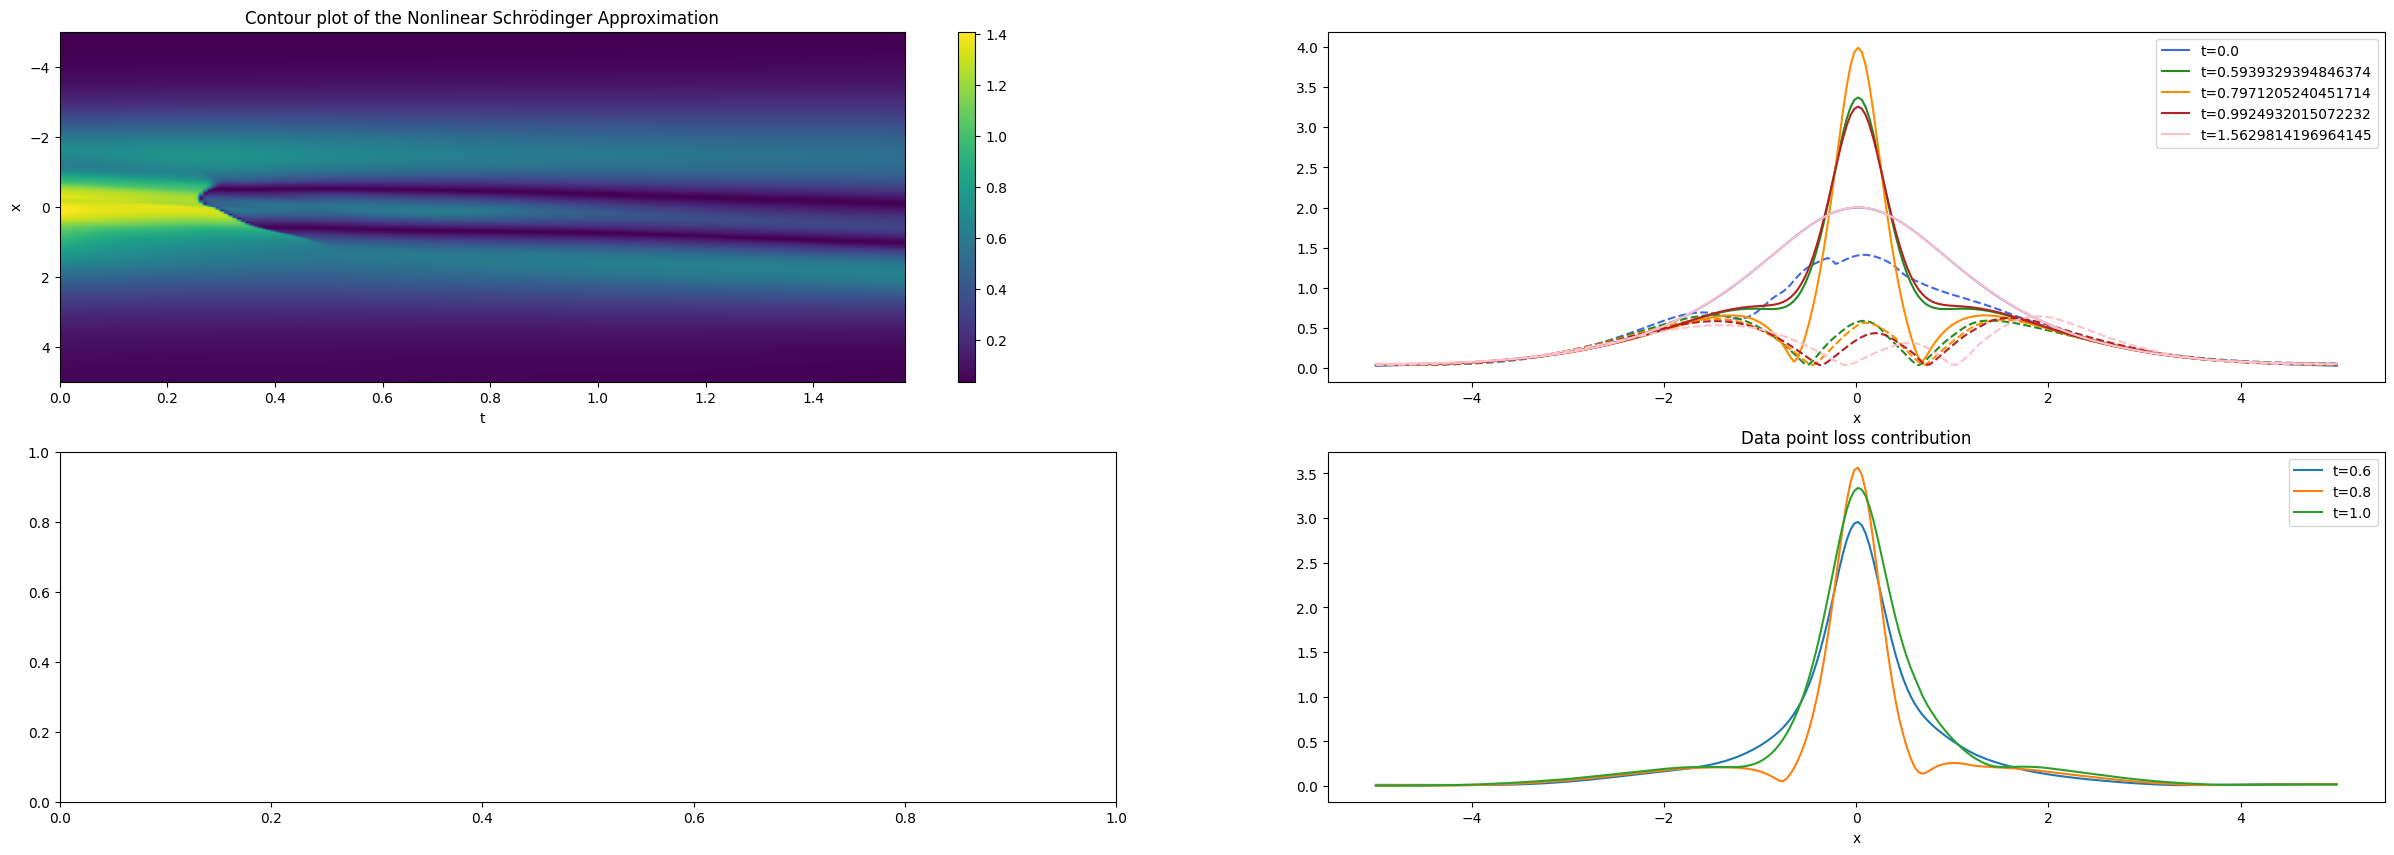

[30000/50001] Boundary L: 0.06349445879459381, Phys L: 0.12245117127895355, Data L: 0.6035788655281067


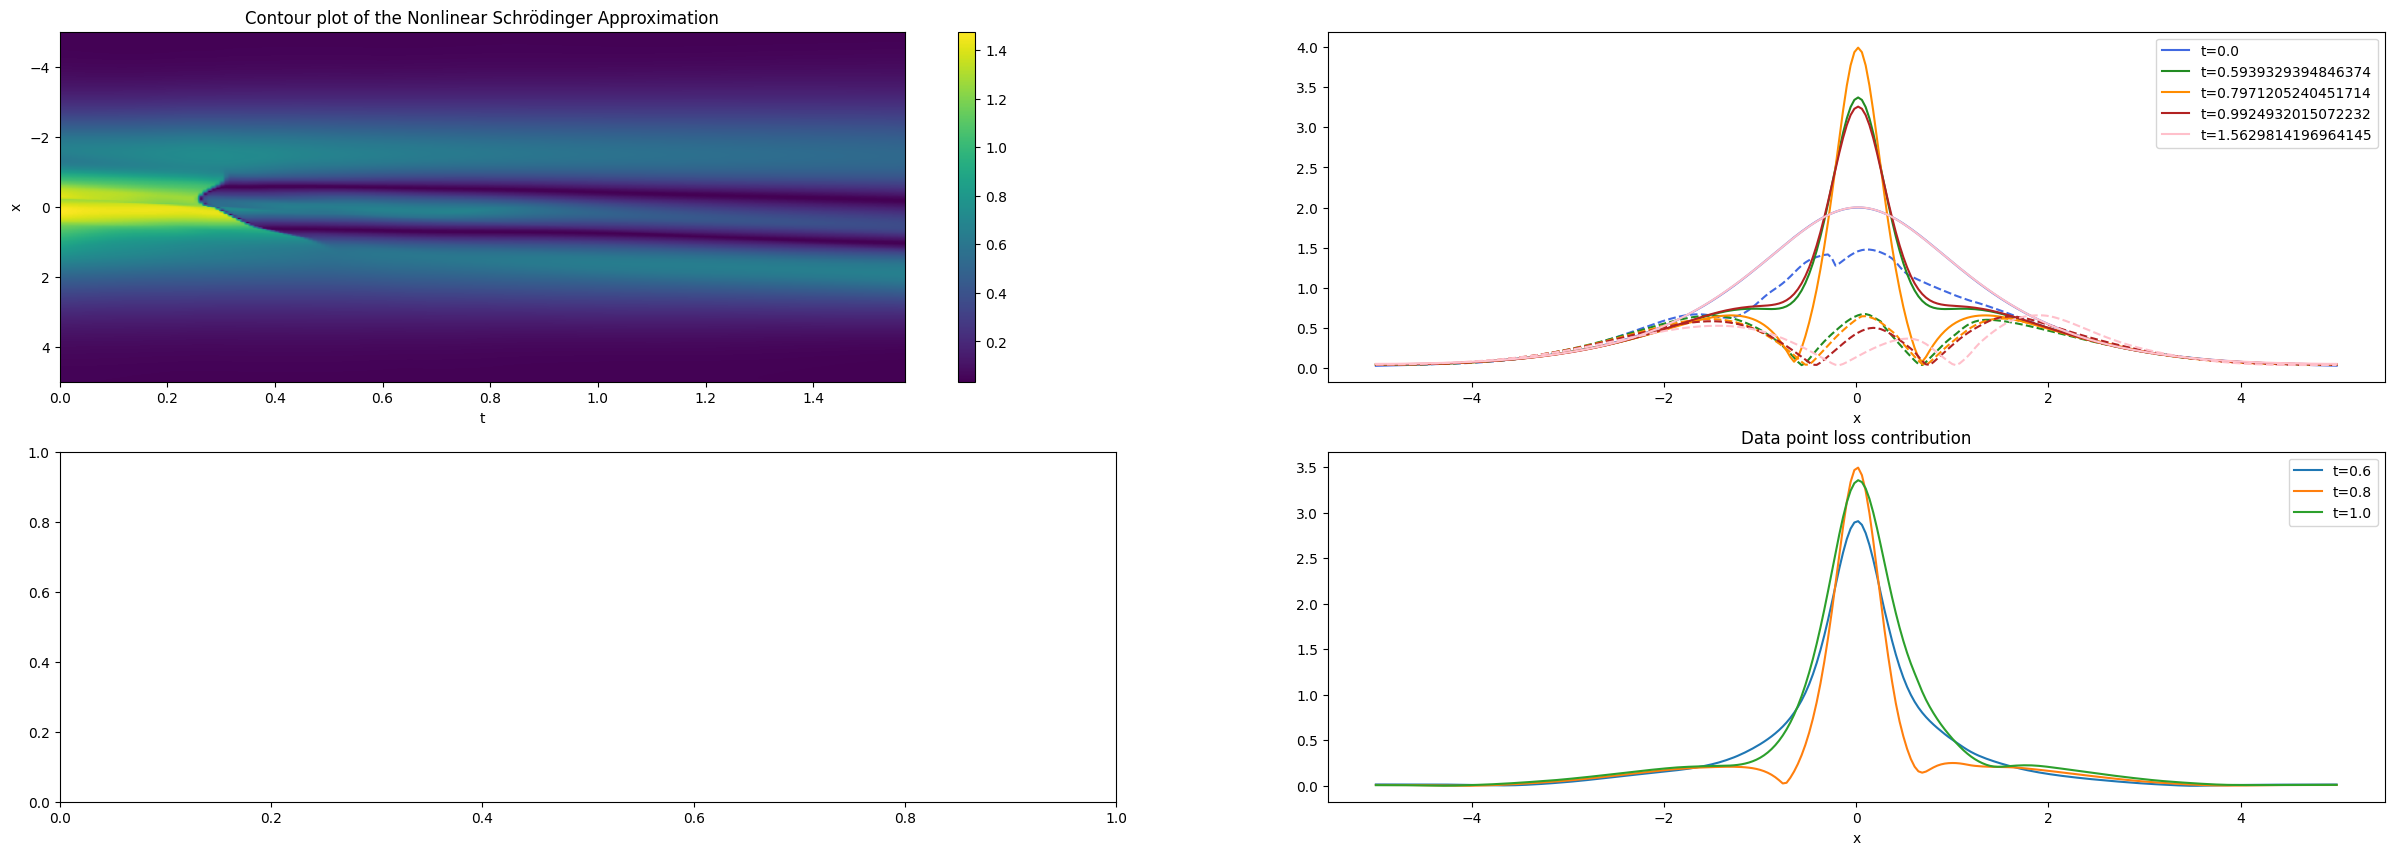

[35000/50001] Boundary L: 0.046343013644218445, Phys L: 0.11585540324449539, Data L: 0.5888110995292664


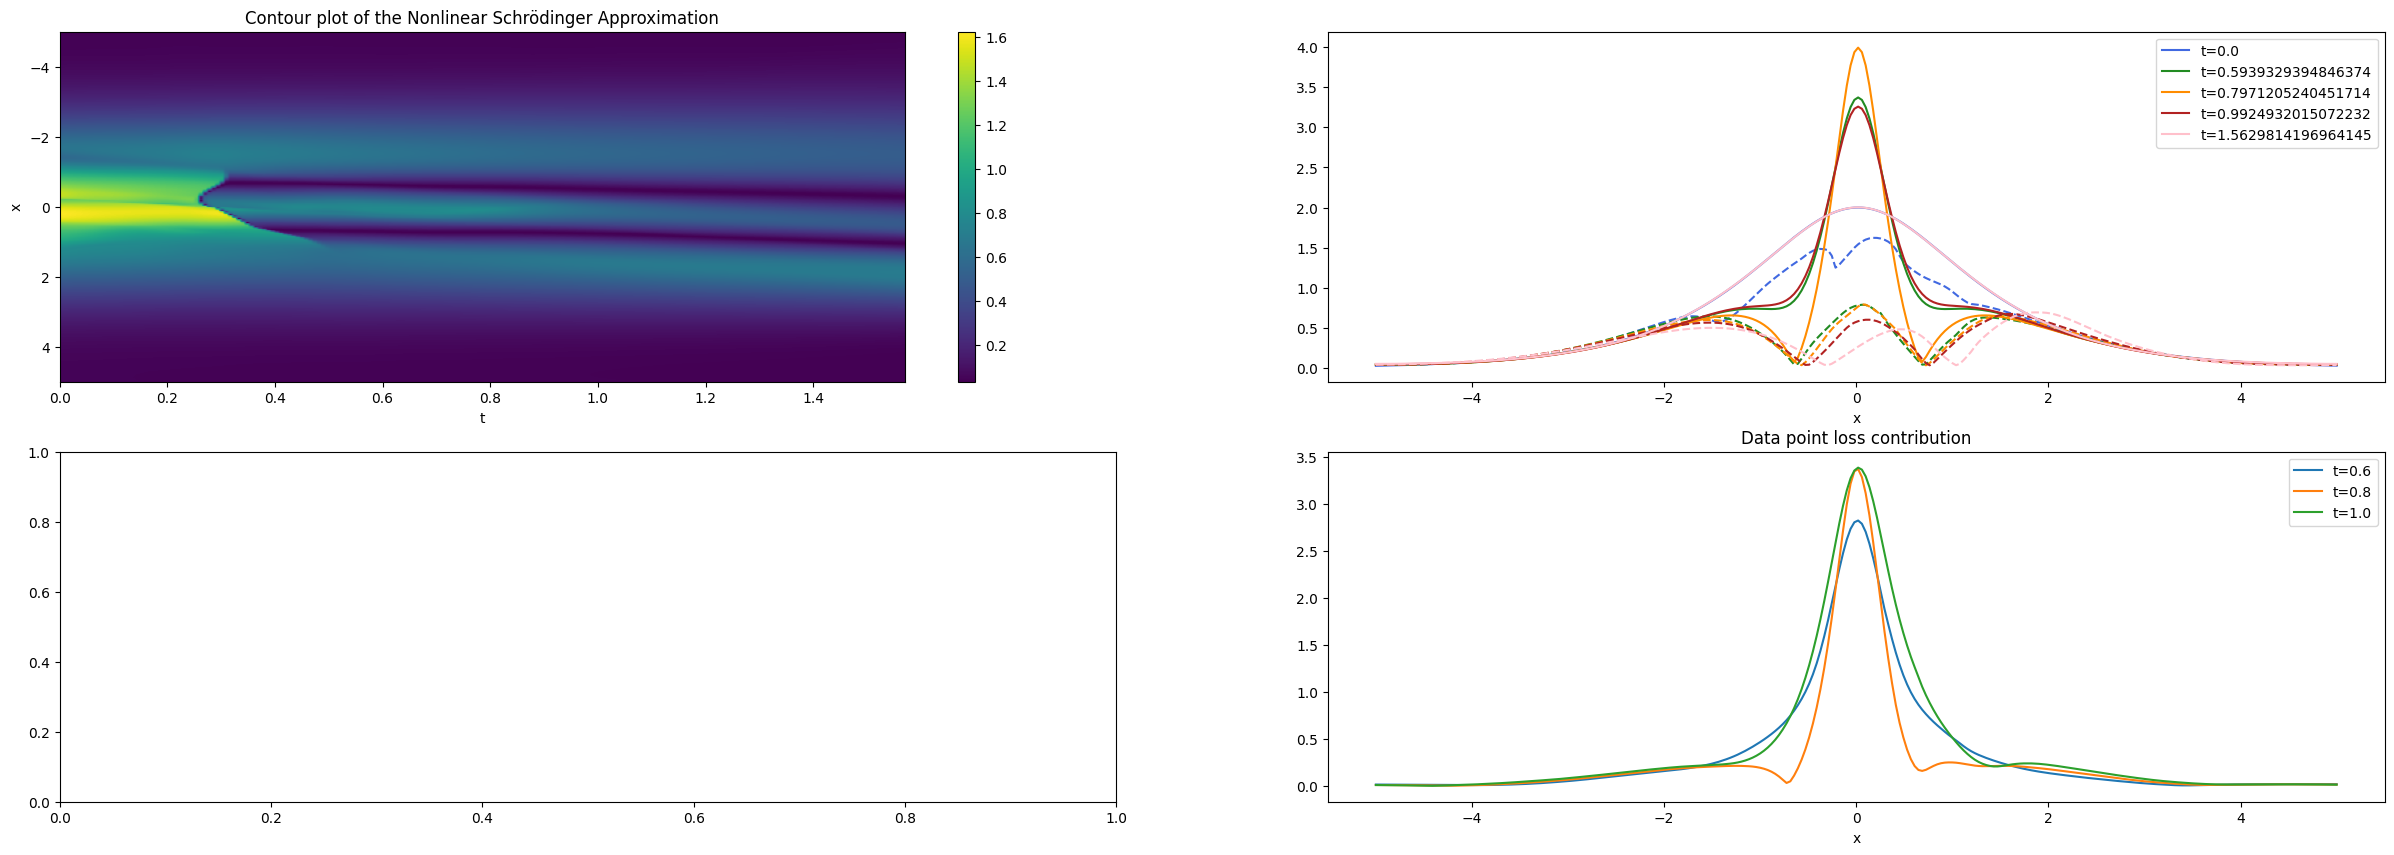

[40000/50001] Boundary L: 0.039312198758125305, Phys L: 0.10950039327144623, Data L: 0.5814074277877808


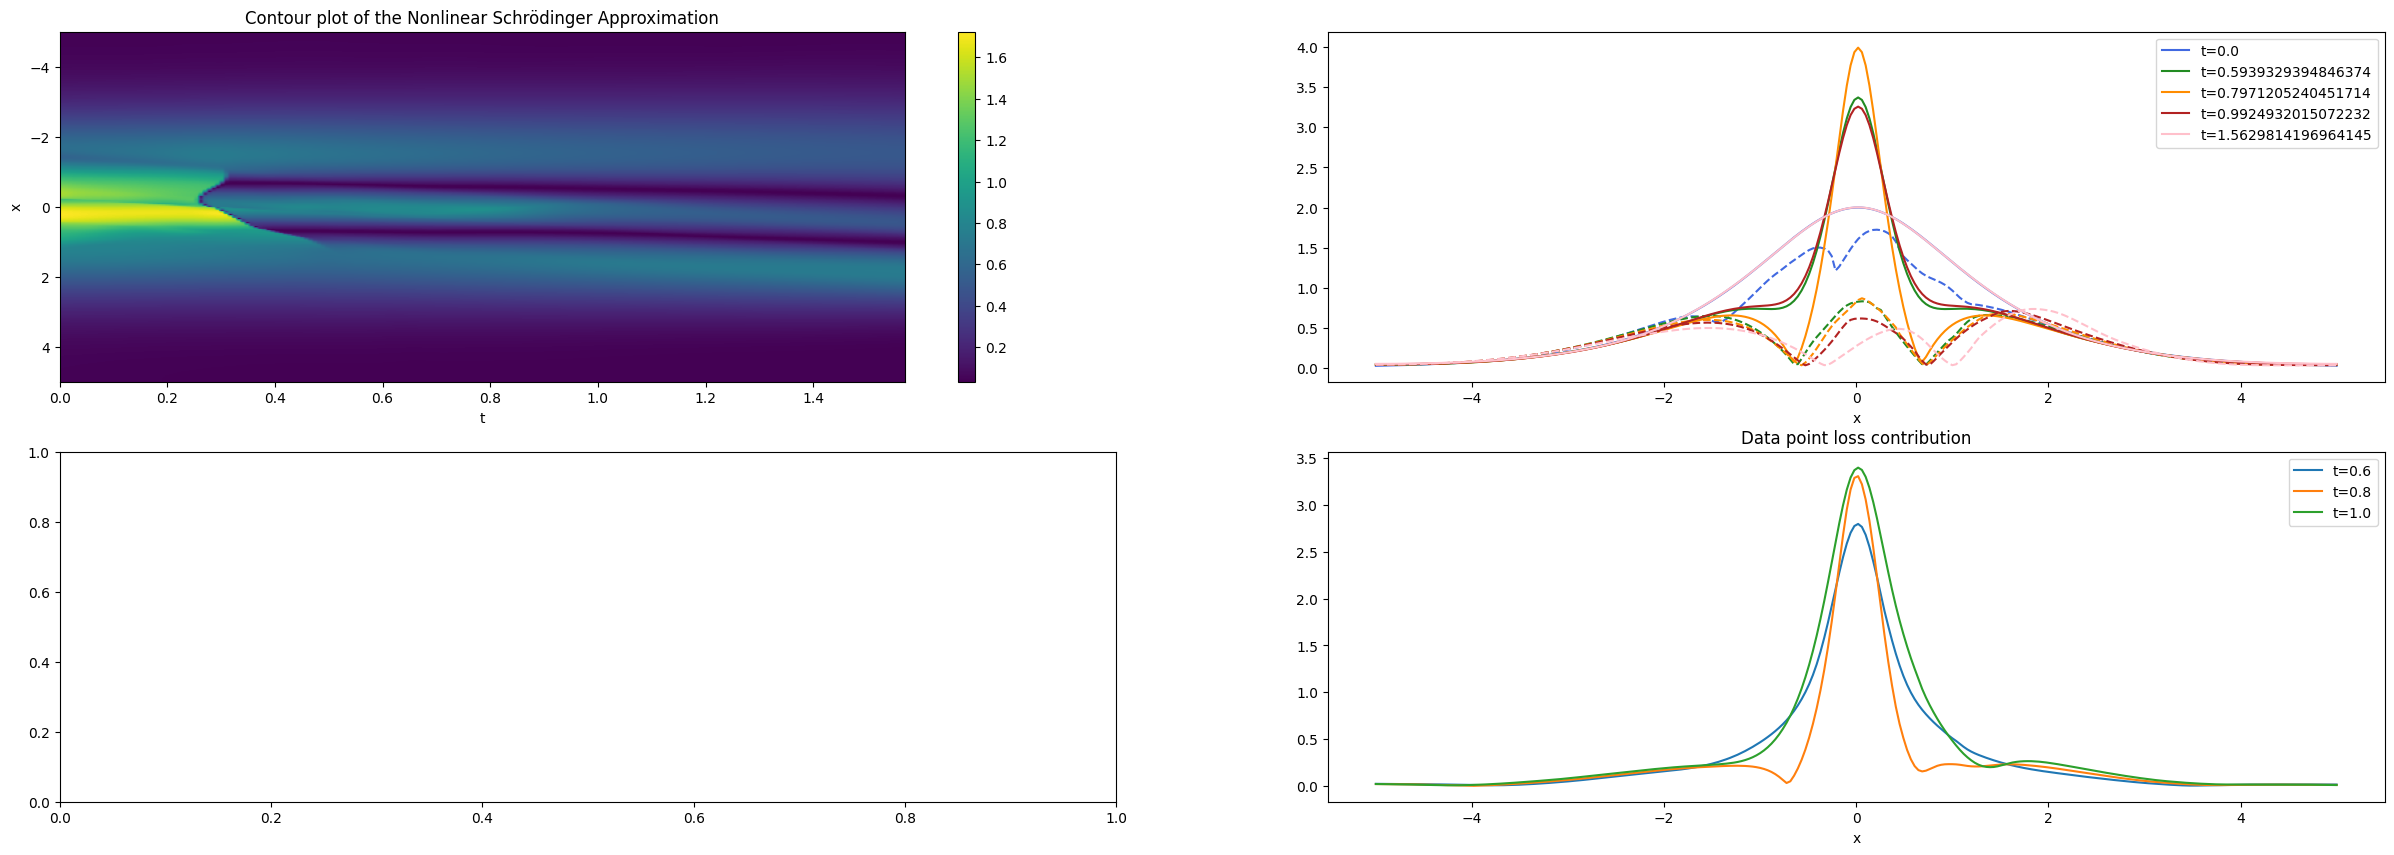

[45000/50001] Boundary L: 0.039395932108163834, Phys L: 0.10769650340080261, Data L: 0.5770529508590698


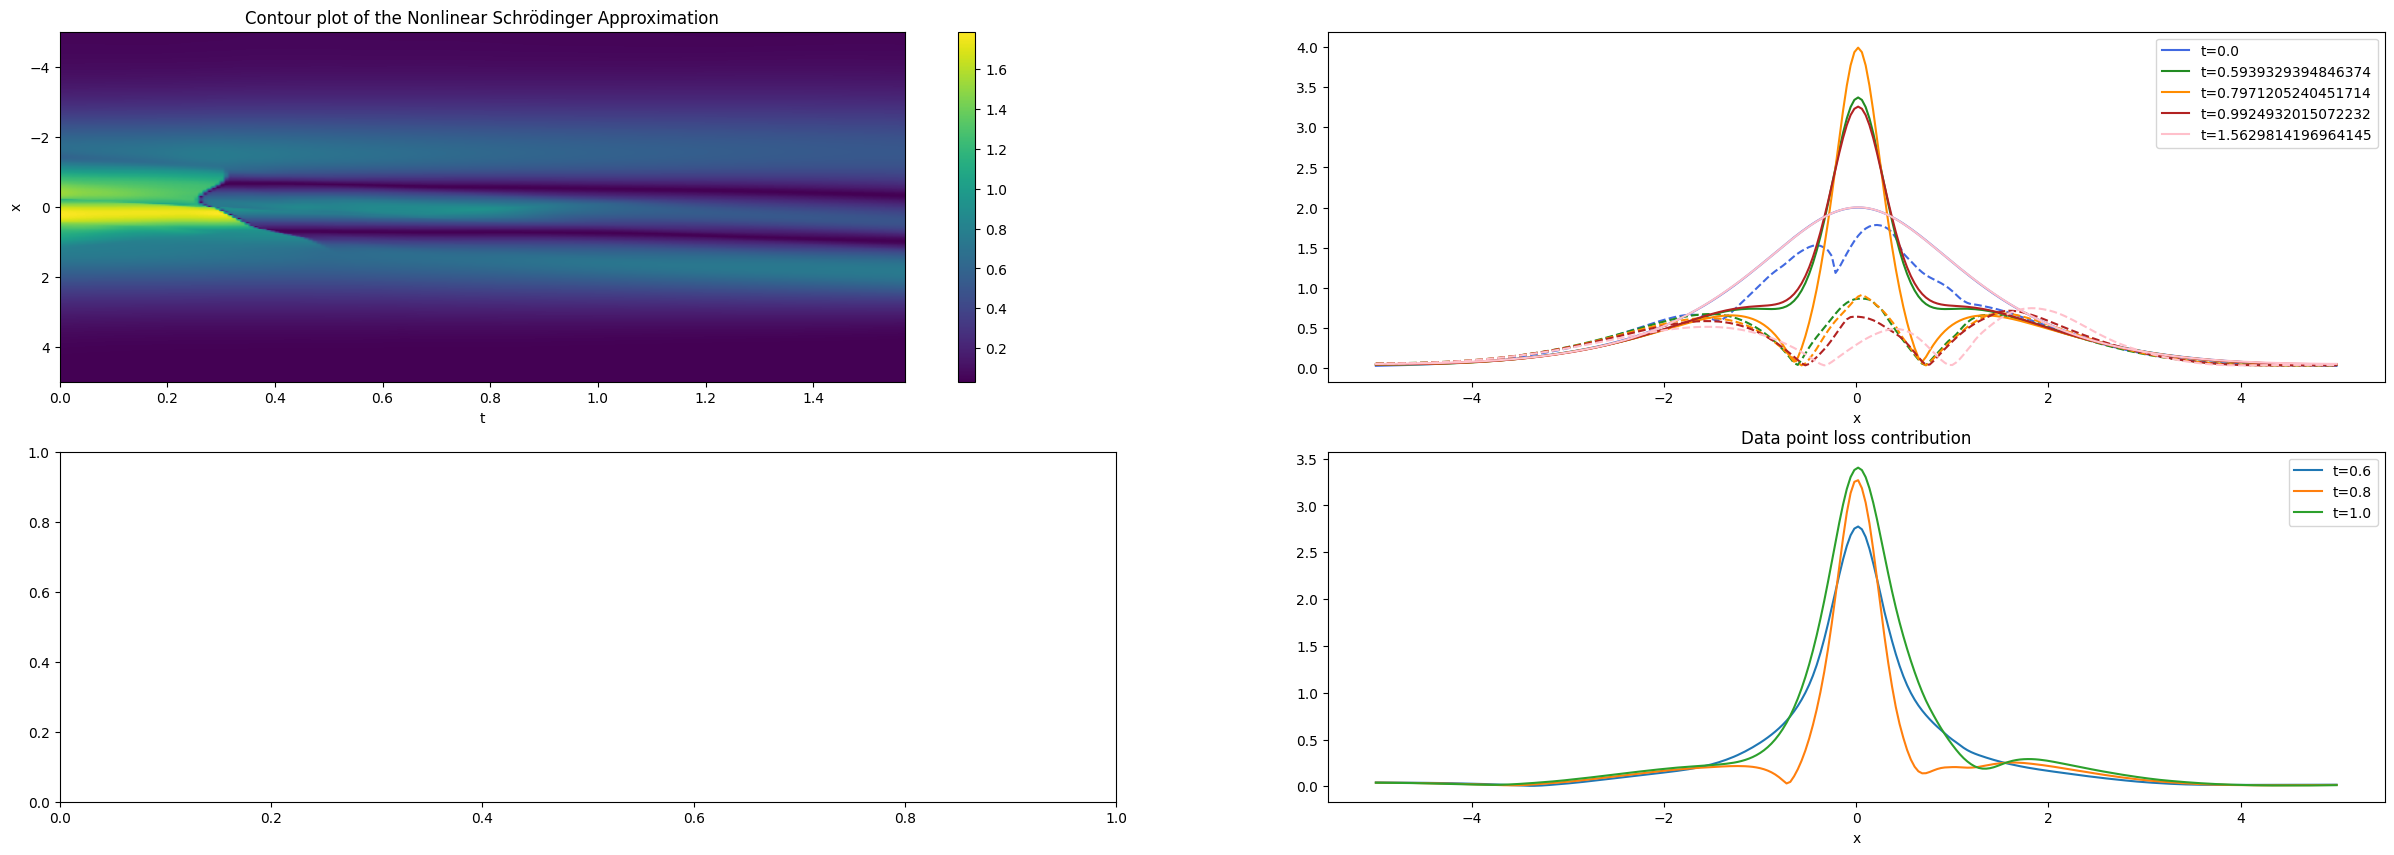

[50000/50001] Boundary L: 0.03371739014983177, Phys L: 0.10326334834098816, Data L: 0.5738441348075867


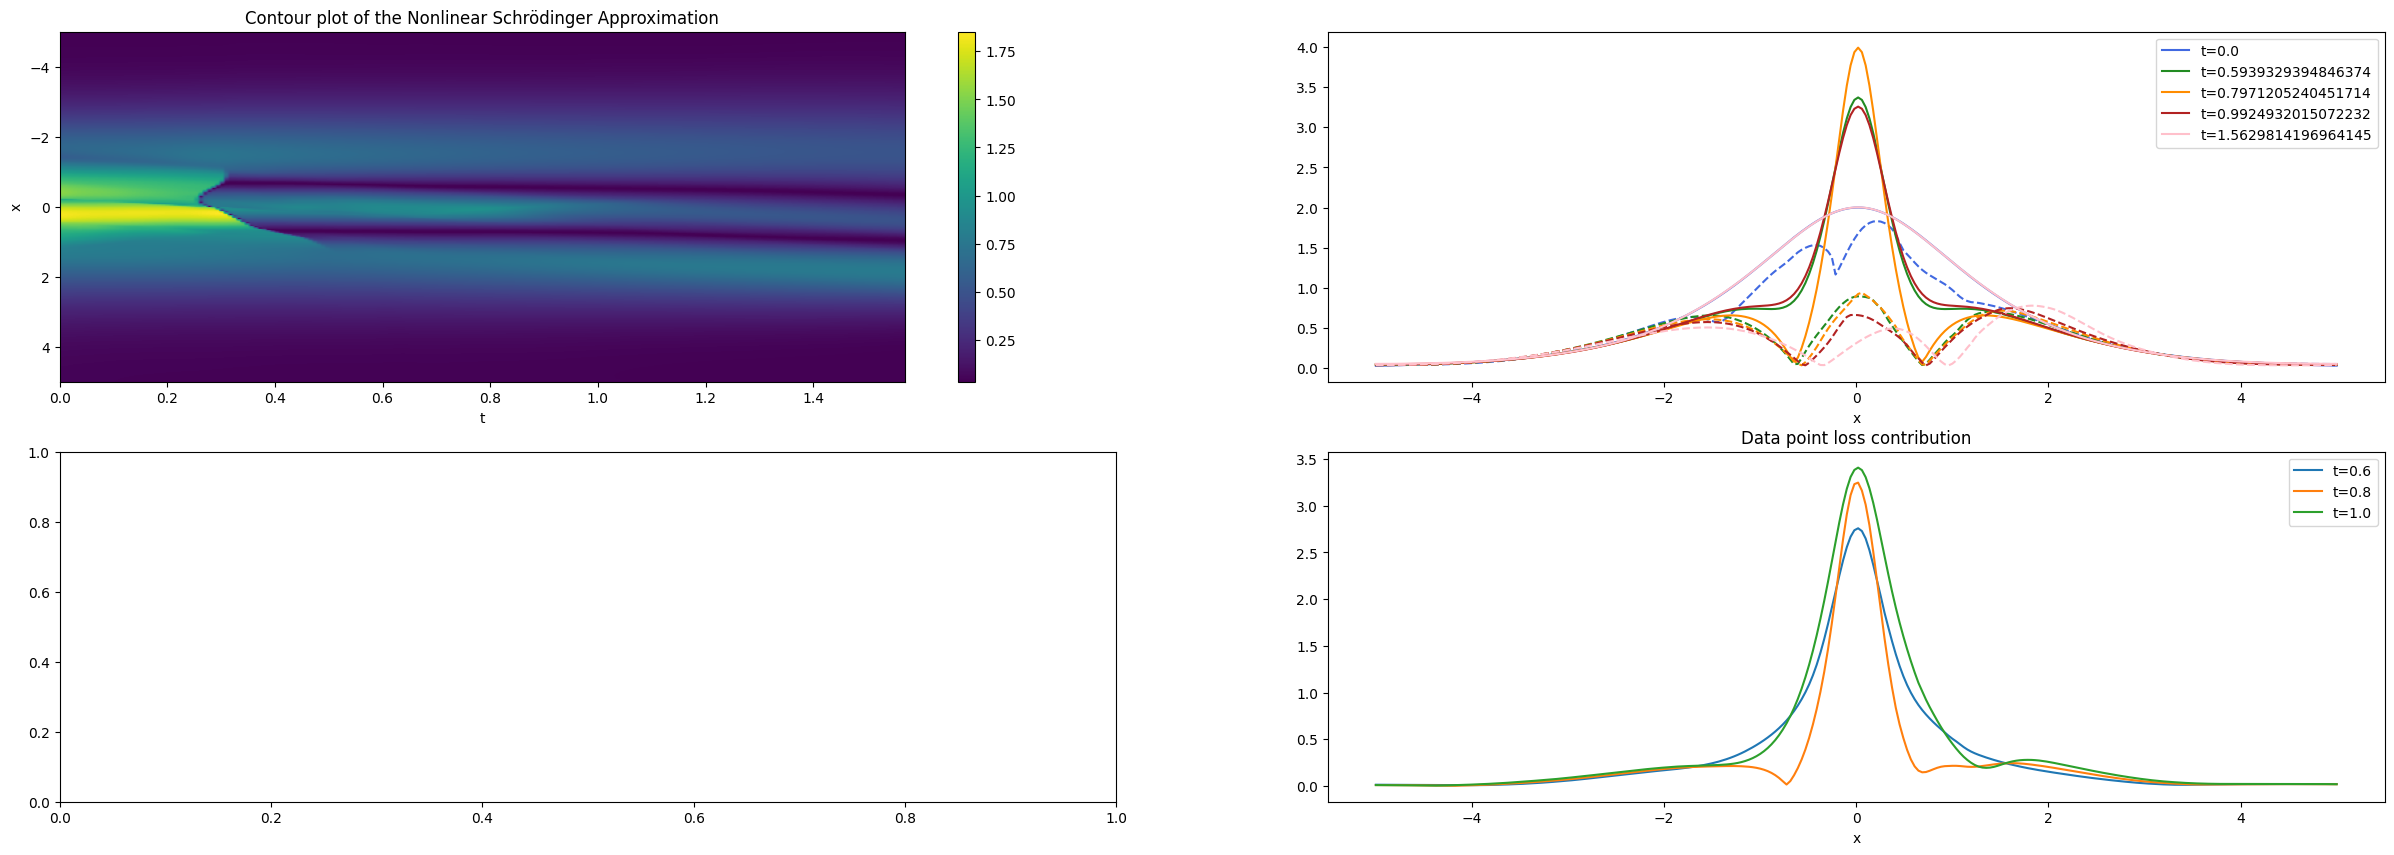

In [166]:
phys_losses = []
losses = []

total_itr = 50001


for i in range(total_itr):
#     optimizer.zero_grad()
    optimizer_u.zero_grad()
    optimizer_f.zero_grad()

    tot_loss, loss1, loss2, loss3 = get_loss(top_boundary_points, 
                                             bottom_boundary_points, 
                                             initial_boundary_points, 
                                             initial_boundary_targets, 
                                             collocation_p, 
                                             train_data, 
                                             train_targets, lambdas=(1e0, 1e0, 1e0))
    losses.append(tot_loss.item())

    tot_loss.backward()
#     optimizer.step()
    optimizer_u.step()
    optimizer_f.step()

    if i% 5000 == 0:
        print(f'[{i}/{total_itr}] Boundary L: {loss1.item()}, Phys L: {loss2.item()}, Data L: {loss3.item()}')
        plot_solution(usol, u, f)

In [ ]:
test_index = 102

print(usol[test_index,test_index])
print(x_phys[0,test_index])
print(t_phys[0,test_index])
test_point = torch.Tensor([x_phys[0,test_index],t_phys[0,test_index]]).cfloat().to(device)
print(u(test_point))

In [ ]:
data = train_data
target = train_targets

u_test = u(torch.Tensor(data).cfloat().to(device))
loss_test = complex_mse_loss(u_test, torch.Tensor(target).cfloat().to(device))
print(loss_test)
plt.plot(u_test.detach().cpu().numpy(), label="Predicted")
plt.plot(torch.Tensor(target).detach().cpu().numpy(), label="True")
plt.legend()

# LBFGS Training

In [ ]:
from torch.optim import LBFGS
lbfgs_optim = LBFGS([*u.parameters(), *f.parameters()], history_size=20, max_iter=4)

In [ ]:
def closure():
    lbfgs_optim.zero_grad()
    tot_loss, _, _, _ = get_loss(top_boundary_points, 
                                             bottom_boundary_points, 
                                             initial_boundary_points, 
                                             initial_boundary_targets, 
                                             collocation_p, 
                                             train_data, 
                                             train_targets, lambdas=(0e0, 0e0, 1e0))
    tot_loss.backward()
    return tot_loss

In [ ]:
lbfgs_itr = 4001


for i in range(lbfgs_itr):
    lbfgs_optim.step(closure)

    if i%500 == 0:
        print(f'[{i}/{lbfgs_itr}] Boundary L: {loss1.item()}, Phys L: {loss2.item()}, Data L: {loss3.item()}')
        fig_lbfgs = plot_solution(usol, u, f)